In [1]:
%matplotlib inline

# Fetching data from the IOOS CSW catalog

This notebook shows a typical workflow to query a [Catalog Service for the Web (CSW)](https://en.wikipedia.org/wiki/Catalog_Service_for_the_Web) and create a request for data endpoints that are suitable for download.

The first step is to create the data filter based on the **geographical** region bounding box, the **time** span, and the CF **variable** standard name.

### Region: west coast

In [2]:
min_lon, max_lon = -123, -121
min_lat, max_lat = 36, 40

bbox = [min_lon, min_lat, max_lon, max_lat]
crs = "urn:ogc:def:crs:OGC:1.3:CRS84"

### Temporal range: past week

In [3]:
from datetime import datetime, timedelta

now = datetime.utcnow()
start, stop = now - timedelta(days=(14)), now - timedelta(days=(7))

### Surface velocity CF names

In [4]:
cf_names = [
    "surface_northward_sea_water_velocity",
    "surface_eastward_sea_water_velocity",
]

In [5]:
print(f"""
*standard_names*: {cf_names}
*start and stop dates*: {start} to {stop}
*bounding box*:{bbox}
*crs*: {crs}""")


*standard_names*: ['surface_northward_sea_water_velocity', 'surface_eastward_sea_water_velocity']
*start and stop dates*: 2019-08-12 23:07:48.423895 to 2019-08-19 23:07:48.423895
*bounding box*:[-123, 36, -121, 40]
*crs*: urn:ogc:def:crs:OGC:1.3:CRS84


Now it is possible to assemble a [OGC Filter Encoding (FE)](http://www.opengeospatial.org/standards/filter) for the search using `owslib.fes`\*. Note that the final result is only a list with all the filtering conditions.

\* OWSLib is a Python package for client programming with Open Geospatial Consortium (OGC) web service (hence OWS) interface standards, and their related content models.

In [6]:
from owslib import fes

def fes_date_filter(start, stop, constraint="overlaps"):
    start = start.strftime("%Y-%m-%d %H:00")
    stop = stop.strftime("%Y-%m-%d %H:00")
    if constraint == "overlaps":
        propertyname = "apiso:TempExtent_begin"
        begin = fes.PropertyIsLessThanOrEqualTo(
            propertyname=propertyname, literal=stop)
        propertyname = "apiso:TempExtent_end"
        end = fes.PropertyIsGreaterThanOrEqualTo(
            propertyname=propertyname, literal=start)
    elif constraint == "within":
        propertyname = "apiso:TempExtent_begin"
        begin = fes.PropertyIsGreaterThanOrEqualTo(
            propertyname=propertyname, literal=start)
        propertyname = "apiso:TempExtent_end"
        end = fes.PropertyIsLessThanOrEqualTo(
            propertyname=propertyname, literal=stop)
    else:
        raise NameError(f"Unrecognized constraint {constraint}")
    return begin, end

### Create the filter

In [7]:
kw = dict(wildCard='*', escapeChar='\\',
          singleChar='?', propertyname='apiso:AnyText')

or_filt = fes.Or([fes.PropertyIsLike(literal=('*%s*' % val), **kw)
                  for val in cf_names])

# Exclude GNOME returns.
not_filt = fes.Not([fes.PropertyIsLike(literal='*GNOME*', **kw)])

begin, end = fes_date_filter(start, stop)
bbox_crs = fes.BBox(bbox, crs=crs)
filter_list = [fes.And([bbox_crs, begin, end, or_filt, not_filt])]

In [8]:
def get_csw_records(csw, filter_list, pagesize=10,
                    maxrecords=1000):
    """Iterate maxrecords/pagesize times until the requested
    value in maxrecords is reached."""
    from owslib.fes import SortBy, SortProperty
    sortby = SortBy([SortProperty("dc:title", "ASC")])
    csw_records = {}
    startposition = 0
    nextrecord = getattr(csw, "results", 1)
    while nextrecord != 0:
        csw.getrecords2(constraints=filter_list, startposition=startposition,
                        maxrecords=pagesize, sortby=sortby)
        csw_records.update(csw.records)
        if csw.results["nextrecord"] == 0:
            break
        startposition += pagesize + 1  # Last one is included.
        if startposition >= maxrecords:
            break
    csw.records.update(csw_records)

In [9]:
from owslib.csw import CatalogueServiceWeb


endpoint = "https://data.ioos.us/csw"

csw = CatalogueServiceWeb(endpoint, timeout=60)
get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = "\n".join(csw.records.keys())

In [10]:
print(f"Found {len(csw.records.keys())} records.\n")
for key, value in list(csw.records.items()):
    print(f"[{value.title}]: {key}")

Found 5 records.

[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
1 km Resolution]: HFR/USWC/1km/hourly/RTV/HFRADAR_US_West_Coast_1km_Resolution_Hourly_RTV_best.ncd
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
2 km Resolution]: HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
500 m Resolution]: HFR/USWC/500m/hourly/RTV/HFRADAR_US_West_Coast_500m_Resolution_Hourly_RTV_best.ncd
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
6 km Resolution]: HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd
[UCSC California Current System ROMS Nowcast 10km]: UCSC


Let us check the 6 km resolution metadata record we found above.

In [11]:
value = csw.records[
    "HFR/USWC/6km/hourly/RTV/"
    "HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd"
]

print(value.abstract)

Surface ocean velocities estimated from HF-Radar are
representative of the upper 0.3 - 2.5 meters of the
ocean.  The main objective of near-real time
processing is to produce the best product from
available data at the time of processing.  Radial
velocity measurements are obtained from individual
radar sites through the U.S. HF-Radar Network.
Hourly radial data are processed by unweighted
least-squares on a 6 km resolution grid of the U.S.
West Coast to produce near real-time surface current
maps.


In [12]:
attrs = [attr for attr in dir(value) if not attr.startswith("_")]
nonzero = [attr for attr in attrs if getattr(value, attr)]
nonzero

['abstract',
 'bbox',
 'identifier',
 'identifiers',
 'modified',
 'references',
 'subjects',
 'title',
 'type',
 'xml']

### What is in there?

In [13]:
value.subjects

['SIO/UCSD',
 'surface_eastward_sea_water_velocity',
 'surface_northward_sea_water_velocity',
 'latitude',
 'longitude',
 'forecast_period',
 'latitude',
 'longitude',
 'time',
 'forecast_reference_time',
 'climatologyMeteorologyAtmosphere']

### Is it up-to-date?

In [14]:
value.modified

'2019-08-26'

### The actual bounding box of the data

In [15]:
bbox = (
    value.bbox.minx, value.bbox.miny,
    value.bbox.maxx, value.bbox.maxy
)
bbox

('-130.36', '30.25', '-115.81', '49.99')

### Now we can "sniff" the URLs with *geolinks*

In [16]:
from geolinks import sniff_link

for ref in value.references:
    if ref["scheme"] == "OPeNDAP:OPeNDAP":
        url = ref["url"]  # save the opendap for later
    geolink = sniff_link(ref["url"])
    msg = (f"geolink: {geolink}\nscheme: {ref['scheme']}\n"
           f"URL: {ref['url']}\n")
    print(msg)

geolink: WWW:LINK
scheme: WWW:LINK
URL: http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd.html

geolink: None
scheme: WWW:LINK
URL: http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd

geolink: None
scheme: OPeNDAP:OPeNDAP
URL: http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd

geolink: OGC:WCS
scheme: OGC:WCS
URL: http://hfrnet-tds.ucsd.edu/thredds/wcs/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd?service=WCS&version=1.0.0&request=GetCapabilities

geolink: OGC:WMS
scheme: OGC:WMS
URL: http://hfrnet-tds.ucsd.edu/thredds/wms/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd?service=WMS&version=1.3.0&request=GetCapabilities

geolink: UNIDATA:NCSS
scheme

For a detailed description of what those `geolink` results mean check the [lookup](https://github.com/OSGeo/Cat-Interop/blob/master/LinkPropertyLookupTable.csv) table.
There are Web Coverage Service (WCS), Web Map Service (WMS),
direct links, and OPeNDAP services available.

We can use any of those to obtain the data but the easiest one to explore interactively is the open OPeNDAP endpoint.

In [17]:
import xarray as xr

ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:       (lat: 367, lon: 234, nProcParam: 7, nSites: 56, time: 69228)
Coordinates:
  * lat           (lat) float32 30.25 30.30394 30.35788 ... 49.9381 49.99204
  * lon           (lon) float32 -130.36 -130.29753 ... -115.86803 -115.805565
  * time          (time) datetime64[ns] 2011-10-01 ... 2019-08-26T21:00:00
    time_run      (time) datetime64[ns] ...
Dimensions without coordinates: nProcParam, nSites
Data variables:
    site_lat      (nSites) float32 ...
    site_lon      (nSites) float32 ...
    site_code     (nSites) |S64 ...
    site_netCode  (nSites) |S64 ...
    procParams    (nProcParam) float32 ...
    time_offset   (time) datetime64[ns] ...
    u             (time, lat, lon) float32 ...
    v             (time, lat, lon) float32 ...
    DOPx          (time, lat, lon) float32 ...
    DOPy          (time, lat, lon) float32 ...
Attributes:
    netcdf_library_version:  4.1.3
    format_version:          HFRNet_1.0.0
    product_version:         HFRNet_

### Select "yesterday" data

In [18]:
from datetime import date, timedelta


yesterday = date.today() - timedelta(days=1)
ds = ds.sel(time=yesterday)

### Compute the speed while masking invalid values

In [19]:
import numpy.ma as ma


u = ds["u"].data
v = ds["v"].data

lon = ds.coords["lon"].data
lat = ds.coords["lat"].data
time = ds.coords["time"].data

u = ma.masked_invalid(u)
v = ma.masked_invalid(v)

This cell is only a trick to show all quiver arrows with the same length,
for visualization purposes,
and indicate the vector magnitude with colors instead.

In [20]:
import numpy as np
from oceans.ocfis import uv2spdir, spdir2uv


angle, speed = uv2spdir(u, v)
us, vs = spdir2uv(np.ones_like(speed), angle, deg=True)

### And now we are ready to create the plot

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from cartopy import feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


LAND = feature.NaturalEarthFeature(
    "physical", "land", "10m",
    edgecolor="face",
    facecolor="lightgray",
)

sub = 2
dx = dy = 0.5
center = -122.416667, 37.783333  # San Francisco.
bbox = lon.min(), lon.max(), lat.min(), lat.max()

In [22]:
def plot_hfradar():
    fig, (ax0, ax1) = plt.subplots(
        ncols=2,
        figsize=(20, 20),
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )


    ax0.set_extent(bbox)
    cs = ax0.pcolormesh(lon, lat, ma.masked_invalid(speed))
    gl = ax0.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    cbar = fig.colorbar(cs, ax=ax0, shrink=0.45, extend="both")
    cbar.ax.set_title(r"speed m s$^{-1}$", loc="left")

    ax0.add_feature(LAND, zorder=0, edgecolor="black")
    ax0.set_title(f"{value.title}\n{ds['time'].values}")

    ax1.set_extent([center[0]-dx-dx, center[0]+dx, center[1]-dy, center[1]+dy])
    q = ax1.quiver(lon[::sub], lat[::sub],
                   us[::sub, ::sub], vs[::sub, ::sub],
                   speed[::sub, ::sub], scale=30)
    ax1.quiverkey(q, 0.5, 0.85, 1, r"1 m s$^{-1}$", coordinates="axes")
    gl = ax1.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax1.add_feature(LAND, zorder=0, edgecolor="black")
    ax1.plot(ds["site_lon"], ds["site_lat"], marker="o", linestyle="none", color="darkorange")
    ax1.set_title("San Francisco Bay area");

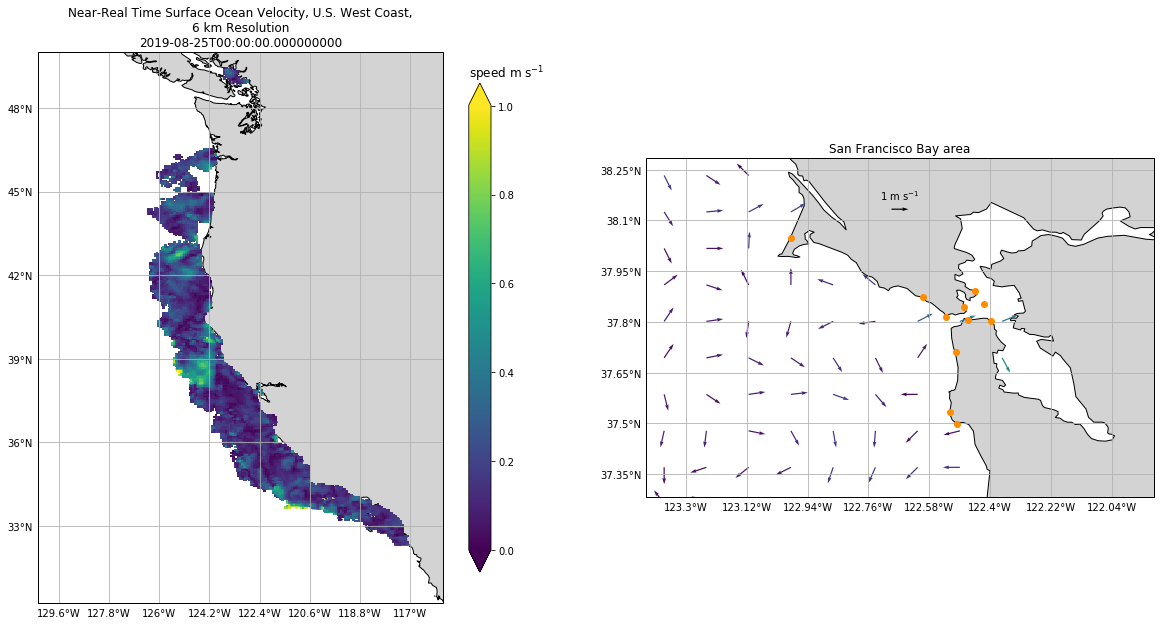

In [23]:
plot_hfradar();

### Try to create your own filter and enjoy data!

```python
filter_list = [
    fes.And(
        [
            bbox_crs,
            begin, end,
            or_filt, not_filt,
        ]
    )
]
```